In [ ]:
%reset

In [1]:
import sys
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/pacpy')
#sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/ecogtools')
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/')


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import os
from scipy import stats
from utils.loadmat import loadmat
from utils.fdr_correct import fdr2
from utils.sci_notation import sci_notation
import scipy.io as spio
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.ticker as ticker

In [4]:
base = '/home/knight/matar/MATLAB/DATA/Avgusta/'
savedir = os.path.join(base, 'PCA', 'bins', 'byROI')
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

In [5]:
filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

In [13]:
df.head()

,Unnamed: 0,subj,task,elec,pattern,cluster,start_idx,end_idx,start_idx_resp,end_idx_resp,RTs,RTs_median,RTs_min,lats,lats_semi_static,lats_static,maxes,ROI
0,0,CP7,DecisionAud,11,SR,1,600,1381.0,57.0,500,2064.096774,1827.0,1253.0,89.0,89.0,689.0,136.943860,R_Temporal
1,1,CP7,DecisionAud,12,S,2,600,983.0,0.0,0,2064.096774,1827.0,1253.0,100.0,100.0,700.0,133.239600,R_Temporal
2,2,CP7,DecisionAud,14,S,2,600,1091.0,0.0,0,2064.096774,1827.0,1253.0,156.0,156.0,756.0,33.416164,R_Temporal
3,3,CP7,DecisionAud,17,sustained,3,612,2230.0,-240.0,500,2064.096774,1827.0,1253.0,101.0,4112.0,4724.0,15.105470,R_Temporal
4,4,CP7,DecisionAud,18,R,4,1454,3049.0,-344.0,500,2064.096774,1827.0,1253.0,723.0,723.0,2177.0,51.039216,R_Motor


## make data

In [144]:
# brainROI = loadmat('/home/knight/matar/MATLAB/DATA/Avgusta/ROIs/brain_ROI.mat')
# brainROI = brainROI['brain_ROI']
# ROIlist = []
# for k in brainROI.keys():
#     ROIlist.extend(brainROI[k].keys())
# np.unique(ROIlist)

In [8]:
ROIlist = df.ROI.unique()
ROIlist

array(['R_Temporal', 'R_Motor', 'R_PFC', 'R_Occip', 'R_Parietal', 'MFG',
       'MFG_premot', 'Broca', 'Pre_centrl', 'Post_centrl', 'ATL', 'STG',
       'Area_37', 'IPL', 'R_MFG', 'R_IFG', 'R_Pre_centrl', 'R_Post_centrl',
       'R_ATL', 'R_STG', 'R_IPL', 'MTG', 'InfTemp', 'R_MedParietal',
       'R_dACC', 'R_SMA', 'dACC', 'MedParietal', 'SMA', 'R_SPL', 'R_MTG',
       'R_InfTemp', 'OFC', 'Occip', 'IFG', 'ITG', 'R_MFG_premot', 'PreSMA',
       'SFG', 'Occip_par', 'SPL', 'PCC', 'FrPole', 'preSMA', 'R_PreSMA',
       'MedOccip'], dtype=object)

In [6]:
#define regions 
PFC = ['MFG_premot','R_MFG_premot', 'Broca', 'FrPole', 'IFG', 'MFG', 'OFC', 'SFG', 'dACC', 'preSMA', 'PreSMA', 'R_IFG', 'R_MFG', 'R_dACC', 'R_PreSMA', 'R_PFC']

motor = ['R_SMA', 'Pre_centrl', 'Post_centrl', 'R_Post_centrl', 'R_Pre_centrl',  'SMA', 'R_Motor']

auditory = ['ITG', 'MTG','R_MTG', 'R_STG', 'STG', 'R_Temporal']

#visual = ['Occip', 'Occip_par', 'MedOccip', 'R_Occip'] #don't include visual ROIs because onset/offset will mess things up

## previously
# PFC = ['Broca','FrPole','IFG','MFG','MFG_premot','OFC','PreSMA','SFG','dACC','preSMA']
# motor = ['Pre_centrl','Post_centrl', 'SMA']
# sensory = ['STG','MTG'] #no occipital bc they have onset/offset

# assign regions
df['region'] = np.nan
regions = dict(zip(['PFC','motor','auditory'], [PFC,motor,auditory]))
for r in regions.keys():
    cond = df.ROI.isin(regions[r])
    #df_lats['region'].loc[cond] = r
    df.loc[cond, 'region'] = r
    
#drop elecs that don't belong to one of predefined regions
df = df.loc[pd.notnull(df['region'])]
df = df.reset_index() #important so that remove the correct rows!!

#drop the sensory elecs that are the wrong coverage for the task (ie temporal in visual task)
auditory_tasks = ['EmoGen', 'EmoRep', 'SelfAud', 'DecisionAud']
visual_tasks = ['FaceEmo', 'FaceGen', 'SelfVis', 'DecisionVis']
df = df.drop(df[(df.region == 'visual') & (df.task.isin(auditory_tasks))].index)
df = df.drop(df[(df.region == 'auditory') & (df.task.isin(visual_tasks))].index)

#rename auditory/visual to just sensory
df.region = df.region.apply(lambda x: 'sensory' if x in(['auditory','visual']) else x)

In [7]:
df.shape

(565, 20)

In [8]:
#drop my data
df = df.query("task not in ['DecisionAud', 'DecisionVis']")

In [9]:
df.shape

(501, 20)

In [11]:
#drop ST6 SelfVis
df[(df.subj == 'ST6')]

,index,Unnamed: 0,subj,task,elec,pattern,cluster,start_idx,end_idx,start_idx_resp,end_idx_resp,RTs,RTs_median,RTs_min,lats,lats_semi_static,lats_static,maxes,ROI,region
578,722,722,ST6,EmoRep,49,SR,2,76,1011.0,52.0,499,1145.159722,1126.0,818.0,277.0,277.0,353.0,51.870973,STG,sensory
579,723,723,ST6,EmoRep,50,SR,2,28,1100.0,-64.0,499,1145.159722,1126.0,818.0,370.0,370.0,398.0,119.193125,STG,sensory
580,724,724,ST6,EmoRep,51,SR,2,57,1000.0,10.0,499,1145.159722,1126.0,818.0,171.0,171.0,228.0,82.607498,Pre_centrl,motor
581,728,728,ST6,SelfAud,49,SR,2,101,989.0,184.0,499,1688.139535,1360.0,941.0,369.0,369.0,470.0,63.125734,STG,sensory
582,729,729,ST6,SelfAud,50,SR,2,63,1521.0,111.0,499,1688.139535,1360.0,941.0,284.0,284.0,347.0,150.983236,STG,sensory
583,730,730,ST6,SelfAud,51,SR,2,70,933.0,93.0,499,1688.139535,1360.0,941.0,325.0,325.0,395.0,78.732346,Pre_centrl,motor


In [18]:
## create data for PFC, motor, sensory
datadir = os.path.join(base, 'Subjs')

PFC_all, motor_all, sensory_all = [pd.DataFrame() for i in range(3)]


for j in df[['subj','task']].drop_duplicates().values:
    subj, task = j

    filename = os.path.join(base, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat(filename)
    data = data_dict['data_zscore']
    active_elecs = data_dict['active_elecs']
    RTs = data_dict['RTs']

#     PFC_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(PFC))].elec.values
#     motor_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(motor))].elec.values
#     sensory_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(sensory))].elec.values

    PFC_elecs = df[(df.subj == subj) & (df.task == task) & (df.region == 'PFC')].elec.values
    motor_elecs = df[(df.subj == subj) & (df.task == task) & (df.region== 'motor')].elec.values
    sensory_elecs = df[(df.subj == subj) & (df.task == task) & (df.region == 'sensory')].elec.values

    eidx = np.in1d(active_elecs, PFC_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        PFC_all = PFC_all.append(pd.DataFrame(datastack, index = RTs_all))

    eidx = np.in1d(active_elecs, motor_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        motor_all = motor_all.append(pd.DataFrame(datastack, index = RTs_all))

    eidx = np.in1d(active_elecs, sensory_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        sensory_all = sensory_all.append(pd.DataFrame(datastack, index = RTs_all))


In [19]:
#format data
PFC_all = PFC_all.sort_index(inplace=False)
PFC_all = PFC_all.fillna(0)

motor_all = motor_all.sort_index(inplace=False)
motor_all = motor_all.fillna(0)

sensory_all = sensory_all.sort_index(inplace=False)
sensory_all = sensory_all.fillna(0)

allRTs = PFC_all.index.values
allRTs = np.array([x for x in allRTs])

allRTs_resp = motor_all.index.values
allRTs_resp = np.array([x for x in allRTs_resp])

allRTs_sensory = sensory_all.index.values
allRTs_sensory = np.array([x for x in allRTs_sensory])

PFC_all = np.array(PFC_all)
motor_all = np.array(motor_all)
sensory_all = np.array(sensory_all)

In [20]:
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

In [21]:
#save data
filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
spio.savemat(filename, {'PFC_all':PFC_all, 'allRTs': allRTs})

filename = os.path.join(savedir, 'rawdata','motor_all.mat')
spio.savemat(filename, {'motor_all':motor_all, 'allRTs_resp': allRTs_resp})

filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
spio.savemat(filename, {'sensory_all':sensory_all, 'allRTs_sensory': allRTs_sensory})

## calculate significance windows

In [72]:
from utils.loadmat import loadmat
from utils import fdr_correct

In [73]:
# minimum_number_of_trials = 100
# filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
# data_dict = loadmat(filename)
# alldata, allRTs_PFC = [data_dict[k] for k in ['PFC_all', 'allRTs']]
# allRTs = allRTs_PFC
# p = 'PFC'
# c = 'red'

# minimum_number_of_trials = 50
# filename = os.path.join(savedir, 'rawdata','motor_all.mat')
# data_dict = loadmat(filename)
# alldata, allRTs = [data_dict[k] for k in ['motor_all', 'allRTs_resp']]
# p = 'motor'
# c = 'blue'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
data_dict = loadmat(filename)
alldata, allRTs = [data_dict[k] for k in ['sensory_all', 'allRTs_sensory']]
p = 'sensory'
c = 'gold'

In [74]:
bins = np.arange(allRTs_PFC.min(), allRTs_PFC.max(), 50) #need to have same bins for all ROIs, base on PFC bins

In [75]:
len(bins)

97

In [76]:
num_trials, dur_dict_t, dur_dict_p, lats = [dict() for i in range(4)]
cnt, start_i, new_b = [0 for i in range(3)]

bl_st = -500

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        
    try:
        end_i = np.where(allRTs <= (b))[-1][-1]
    except:
        end_i = 0
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
        
    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    data = alldata[start_i:end_i+1,abs(bl_st):]
    rt = np.floor(allRTs[start_i:end_i+1].mean())
    lats[int(rt)] = np.argmax(data.mean(axis =0))
    
    tvals, pvals = [[] for i in range(2)]
    for j in np.arange(0, data.shape[1]):
        (t, pval) = stats.ttest_1samp(data[:,j], 0)
        tvals.append(t)
        pvals.append(pval)
    
    dur_dict_t[rt] = tvals
    dur_dict_p[rt] = pvals
    
    num_trials[rt] = alldata[start_i:end_i+1,:].shape[0]
    
# save
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
pd.DataFrame(dur_dict_t).to_csv(filename, index = False)

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_pvals.csv' %(p))
pd.DataFrame(dur_dict_p).to_csv(filename, index = False)

num_trials = pd.DataFrame([num_trials]).transpose()
num_trials.columns = ['dur']
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'num_trials_%s.csv' %(p))
pd.DataFrame(num_trials).to_csv(filename)

lats = pd.DataFrame([lats]).transpose()
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'latencies_%s.csv' %(p))
pd.DataFrame(lats).to_csv(filename)
filename

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI/trace_data/sigvalues/latencies_sensory.csv'

In [77]:
#calculate threshold
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_pvals.csv' %(p))
df_p = pd.read_csv(filename)

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
df_t = pd.read_csv(filename)

minbin = num_trials.dur.argmin() #bin with least number of trials

pvals = df_p[str(minbin)] #pvalues for bin with least number of trials

thr = fdr2(pvals, q = 0.05) #fdr threshold for bin with least number of trials

tvals = df_t[str(minbin)]
t_thresh  = float(tvals[pvals == thr]) #t value that corresponds to pvalue


# use threshold to define significance windows for each bin for dur and response
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
df_t = pd.read_csv(filename)

H_dur = (df_t>t_thresh).astype('int')


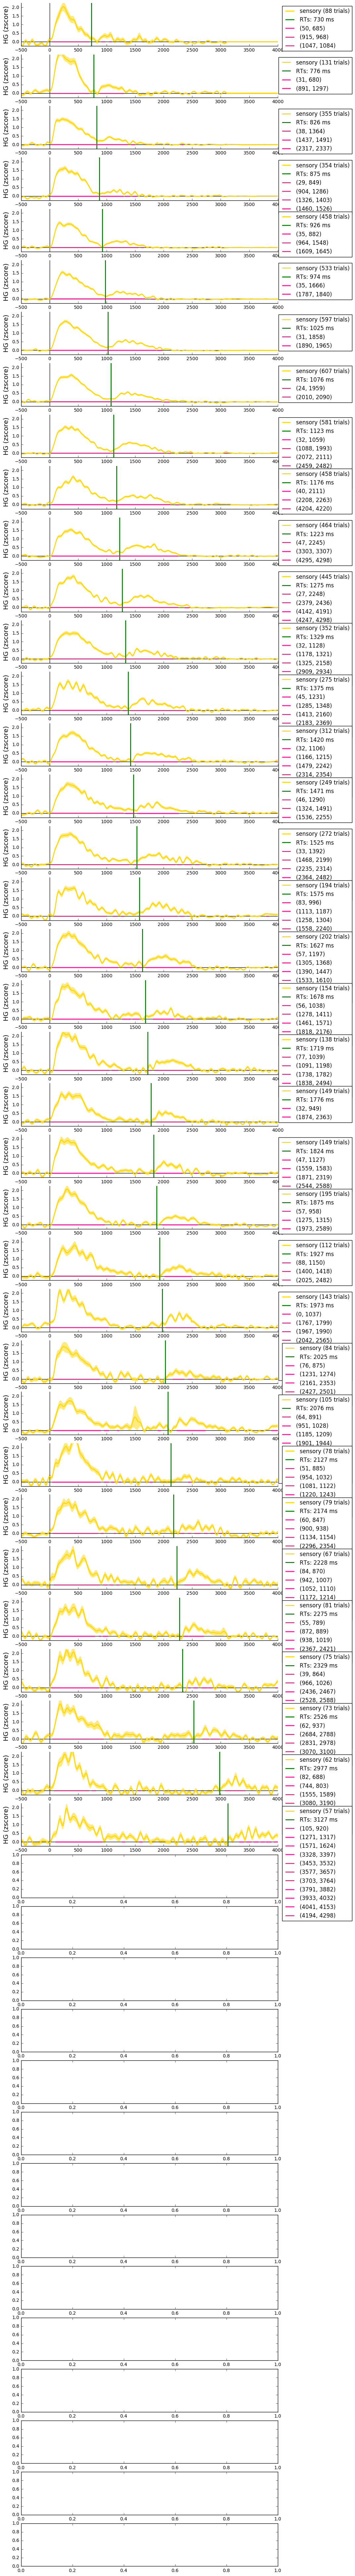

In [78]:
df_idx = pd.DataFrame(columns = ['start_idx','end_idx'])

#plot - only 1 trace with significant windows on x axis
f, ax = plt.subplots(50, 1, figsize = (10,100))
rts, lats =[[] for i in range(2)]
cnt, start_i, start_i_resp, new_b = [0 for i in range(4)]

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
    
    try:
        end_i = np.where(allRTs <= (b))[-1][-1]
    except:
        end_i = 0
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    data = alldata[start_i:end_i+1,:]
    rts.append(allRTs[start_i:end_i+1].mean())

    #save data
    filename = os.path.join(savedir, 'trace_data', 'trace_data_%s_%ims.mat' %(p, rts[-1]))
    spio.savemat(filename, {'data':data, 'rt': allRTs[start_i:end_i+1]})
    filename = os.path.join(savedir, 'trace_data', 'trace_data_%s_%ims_mean.mat' %(p, rts[-1]))
    spio.savemat(filename, {'data':data.mean(axis = 0)})
    
    #calculate windows
    H = H_dur[str(np.floor(rts[-1]))]
    
    difference = np.diff(H, n = 1, axis = 0)
    start_idx = np.where(difference==1)[0]+1
    end_idx = np.where(difference == -1)[0]

    if start_idx.size > end_idx.size: #last chunk goes until end
        end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

    elif start_idx.size < end_idx.size:
        start_idx = np.append(0, start_idx) #starts immediately significant

    if (start_idx.size!=0):
        if (start_idx[0] > end_idx[0]): #starts immediately significant
            start_idx = np.append(0, start_idx)

    if (start_idx.size!=0):
        if (end_idx[-1] < start_idx[-1]):#significant until end
            end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

    #plot   
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = c, lw = 2, label = '%s (%i trials)' %(p, len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = c, label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i+1].mean())) 

    if start_idx.size>0:
        for i, s in enumerate(start_idx):
            tmp = np.arange(s, end_idx[i])
            start = s
            finish = end_idx[i]
            ax[cnt].plot(tmp, np.zeros(tmp.size), color = 'deeppink', linewidth = 2, label = (start, finish))
            
        tmp = pd.DataFrame([start_idx, end_idx]).transpose()
        tmp = tmp.set_index(np.tile(np.floor(rts[-1]), len(start_idx)))
        tmp.columns = ['start_idx','end_idx']
        df_idx = df_idx.append(tmp)

    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 14)
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 4000])
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1))            
                
    cnt += 1
    
filename = os.path.join(savedir, 'trace_data','sigvalues', 'binned_RTs_sigwindow_%s.png' %(p))
#f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RTs_sigwindow_%s.csv' %(p))
#df_idx.to_csv(filename)


In [42]:
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

## custom bins

In [7]:
minimum_number_of_trials = 100
filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
data_dict = loadmat(filename)
alldata, allRTs = [data_dict[k] for k in ['PFC_all', 'allRTs']]
p = 'PFC'
c = 'firebrick'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','motor_all.mat')
data_dict = loadmat(filename)
alldata_resp, allRTs_resp = [data_dict[k] for k in ['motor_all', 'allRTs_resp']]
p = 'motor'
c = 'navy'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
data_dict = loadmat(filename)
alldata_stim, allRTs_stim = [data_dict[k] for k in ['sensory_all', 'allRTs_sensory']]
p = 'sensory'
c = 'green'

In [8]:
allRTs_PFC, alldata_PFC = allRTs, alldata

For the figure with traces for ROI bins, 
* drop the 1st two and bins with RTs > 2 sec, 

and then you can take every X plot for the total of 5 panels 
(that's how many we had in the bins by activity type, right?)


In [13]:
binlist = np.array([int(x) for x in rts]) # plot for all rt bins so that can decide on custom bins

In [14]:
binlist = binlist[1:]
binlist = binlist[binlist<2000]
print binlist
binlist = binlist[::7]
print binlist

[ 758  801  841  879  920  959 1001 1040 1081 1119 1157 1200 1241 1281 1325
 1359 1401 1438 1474 1519 1559 1599 1637 1681 1718 1761 1796 1843 1880 1919
 1959]
[ 758 1040 1325 1599 1880]


/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI


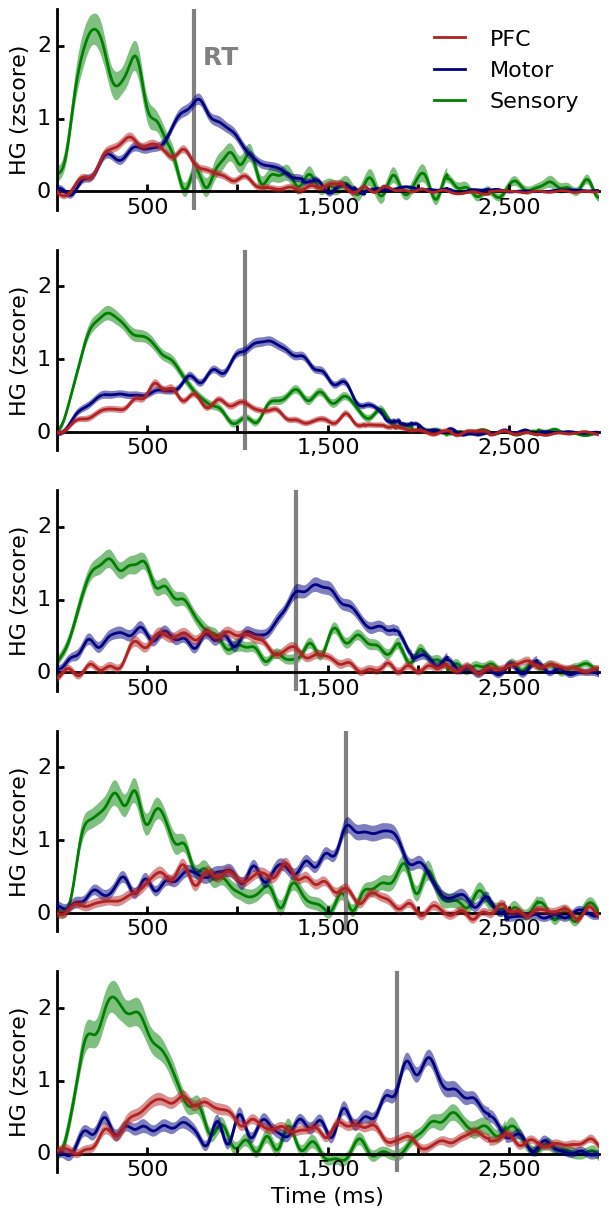

In [15]:
bins = np.arange(allRTs_PFC.min(), allRTs_PFC.max(), 40)

f, ax = plt.subplots(5, 1, figsize = (7,15))
#f, ax = plt.subplots(50, 1, figsize = (10,100)) #plot for all bins so can decide on custom bins


#binlist =[925, 1275, 1624, 1975, 2327]
#binlist = [524, 576, 624, 676, 726]

cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0
rts = []

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
        start_i_stim = end_i_stim+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    try:
        end_i_stim = np.where(allRTs_stim <= (b))[-1][-1]
    except:
        end_i_stim = 0
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    if len(np.arange(start_i_resp, end_i_resp+1))<50:
        continue
        
    if len(np.arange(start_i_stim, end_i_stim+1))<50:
        continue
                
    data = alldata[start_i:end_i+1,:]
    data_resp = alldata_resp[start_i_resp:end_i_resp+1,:]
    data_stim = alldata_stim[start_i_stim:end_i_stim+1,:]
        
    rt = allRTs[start_i:end_i+1].mean()
    rts.append(rt)
    
    if int(rts[-1]) not in (binlist):
        #print int(rts[-1])
        continue
    
    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)
    

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'firebrick', lw = 2, label = 'PFC', zorder = 10)# (%i trials)') %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 10, edgecolor = 'None', facecolor = 'firebrick', label = None)

    ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'navy', lw = 2, label = 'Motor', zorder = 9)# (%i trials)') %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 9, edgecolor = 'None', facecolor = 'navy', label = None)

    ax[cnt].plot(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0), color = 'green', lw = 2, label = 'Sensory')# (%i trials)') %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_stim, axis = 0)/np.sqrt(data_stim.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0)+sem, data_stim.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'green', label = None)
    
    ax[cnt].axvline(x = rt, color = 'gray', lw = 3)#, label = 'RT: %i ms' %(allRTs[start_i:end_i+1].mean()))
    
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].spines['bottom'].set_position('zero')
    ax[cnt].spines['bottom'].set_linewidth(2)
    ax[cnt].spines['left'].set_linewidth(2)
    
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 16)
    ax[cnt].set_ylim([-0.25, 2.5])
#     ax[cnt].set_xlim([-500, 3000])
#     ax[cnt].set_xticks([-500, 0, 1000, 2000, 3000])
    ax[cnt].set_yticks(np.arange(0, 3, 1))

    ax[cnt].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[cnt].patch.set_facecolor('white')

    ax[cnt].xaxis.set_tick_params(labelsize = 16, length = 5, width = 2)
    ax[cnt].yaxis.set_tick_params(labelsize = 16, length = 5, width = 2)
    ax[cnt].set_xlim([0, 3000])
    ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'on', right = 'off', left = 'on')
    ax[cnt].spines['bottom'].set_bounds(0, 3000)
    ax[cnt].set_xticks(np.arange(0, 3000, 500))

    plt.setp(ax[cnt].get_xticklabels()[::2], visible=False)
    #plt.setp(ax[cnt].get_yticklabels()[::2], visible=False)
    #ax[cnt].set_ylim(bottom=5)
    ax[cnt].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[cnt].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    
    handles, labels = ax[0].get_legend_handles_labels()
    lgnd = ax[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1), frameon = False, fontsize = 16)
 
    #print (len(allRTs[start_i:end_i+1]),(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    
    cnt += 1
    
ax[cnt-1].set_xlabel('Time (ms)', fontsize = 16)
            
    
    
ax[0].annotate('RT', xy = (binlist[0]+50, 1.75), color = 'gray', fontsize = 18, weight = 'bold')
#ax[1].annotate('sustained', xy = (40, 1.1), color = 'r', fontsize = 14, weight = 'bold')
#ax[1].annotate('response', xy = (750, 1.1), color = 'b', fontsize = 14, weight = 'bold')
                 
filename = os.path.join(savedir, 'binned_RTs_custom_all_dark_ROIs.png')

f.savefig(filename,bbox_inches='tight', dpi = 150)

print savedir

In [53]:
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

## single trials

In [12]:
minimum_number_of_trials = 100
filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
data_dict = loadmat(filename)
alldata_PFC, allRTs_PFC = [data_dict[k] for k in ['PFC_all', 'allRTs']]
p = 'PFC'
c = 'firebrick'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','motor_all.mat')
data_dict = loadmat(filename)
alldata_resp, allRTs_resp = [data_dict[k] for k in ['motor_all', 'allRTs_resp']]
p = 'motor'
c = 'navy'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
data_dict = loadmat(filename)
alldata_stim, allRTs_stim = [data_dict[k] for k in ['sensory_all', 'allRTs_sensory']]
p = 'sensory'
c = 'green'

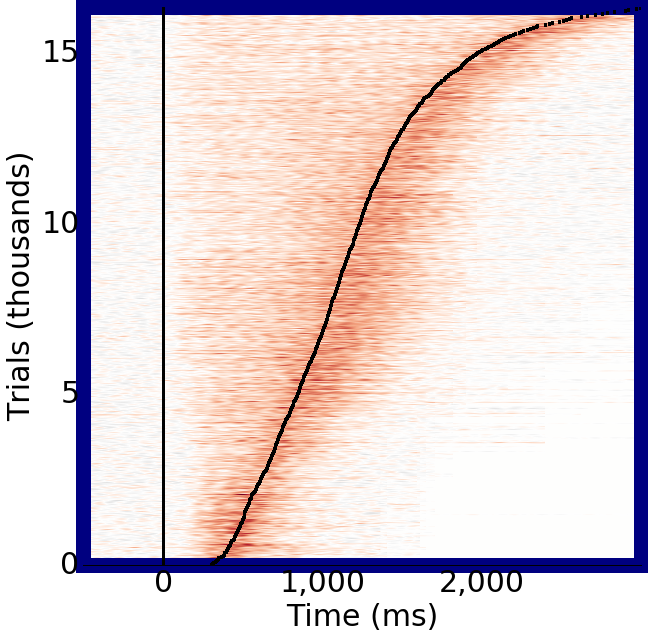

In [47]:
#plot
alldata = alldata_resp
allRTs = allRTs_resp
p, c = 'motor', 'navy'
fs = 30

#drop any trial that is >3000ms
idx = (allRTs<3000)
allRTs = allRTs[idx]
alldata = alldata[idx,:max(allRTs+500)]

f,ax = plt.subplots(figsize = (10, 10))
cm = plt.get_cmap('RdGy_r')

ax.autoscale(enable = True, tight = True)
ax.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.xaxis.set_tick_params(labelsize = fs, width = 0)
ax.yaxis.set_tick_params(labelsize = fs, width = 0)
ax.set_xticks(np.arange(0, 3000, 1000))
ax.axvline(x = 0, lw = 3, color = 'black')
ax.set_ylabel('Trials (thousands)', fontsize = fs)
ax.set_xlabel('Time (ms)', fontsize = fs)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.0f')%(y*1e-3)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#cax = ax.pcolormesh(np.arange(-500, alldata.shape[1]-500), np.arange(0, len(allRTs)), alldata * (abs(alldata)>1.96), zorder = 0)# , cmap = plt.get_cmap('bwr_r'))
img = ndimage.gaussian_filter1d(alldata, axis = 0, sigma = 10, order=0) #gaussian smooth trials
cax = ax.imshow(img, aspect = 'auto', origin = 'lower', extent = (-500, img.shape[1]-500, 0, len(allRTs)), cmap = cm)
cax.set_clim(vmin=-3,vmax=3)

for j in np.arange(len(allRTs)):
    ax.plot((allRTs[j], allRTs[j]), (j-0.5, j+0.5), 'black', linewidth = 3,zorder = 1)


#cbar = f.colorbar(cax, ticks = [-3, 0 , 3], orientation = 'vertical')
#cbar.ax.set_ylabel('HG (zscore)', fontsize = 24)
#cbar.ax.tick_params(labelsize=24) 

autoAxis = ax.axis()
rec = Rectangle((autoAxis[0],autoAxis[2]),(autoAxis[1]-autoAxis[0]),(autoAxis[3]-autoAxis[2]),fill=False, lw=15, color = c)
rec = ax.add_patch(rec)
rec.set_clip_on(False)


filename= os.path.join(base, 'PCA', 'exit', '_'.join(['singletrials','smooth',p, 'nobar']))
plt.savefig(filename, bbox_inches = 'tight', dpi = 150)

## generate RTs for a bin

In [111]:
bins

array([ 333,  383,  433,  483,  533,  583,  633,  683,  733,  783,  833,
        883,  933,  983, 1033, 1083, 1133, 1183, 1233, 1283, 1333, 1383,
       1433, 1483, 1533, 1583, 1633, 1683, 1733, 1783, 1833, 1883, 1933,
       1983, 2033, 2083, 2133, 2183, 2233, 2283, 2333, 2383, 2433, 2483,
       2533, 2583, 2633, 2683, 2733, 2783, 2833, 2883, 2933, 2983, 3033,
       3083, 3133, 3183, 3233, 3283, 3333, 3383, 3433, 3483, 3533, 3583,
       3633, 3683, 3733, 3783, 3833, 3883, 3933])

In [109]:
bins = np.arange(allRTs.min(), allRTs.max(), 50)

rt, lats =[[] for i in range(2)]
rts = dict()
cnt, start_i, start_i_resp, new_b = [0 for i in range(4)]

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    print (previous_b, new_b, end_i+1 - start_i, allRTs[start_i:end_i+1].mean())

    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    rt = allRTs[start_i:end_i+1].mean()
    rts['RT_' + str(int(rt))] = allRTs[start_i:end_i+1]

(0, 333, 1, 333.0)
(333, 383, 8, 349.875)
(383, 433, 19, 406.05263157894734)
(433, 483, 34, 460.20588235294116)
(483, 533, 43, 508.86046511627904)
(533, 583, 56, 557.64285714285711)
(583, 633, 102, 610.39215686274508)
(633, 683, 93, 659.9677419354839)
(683, 733, 133, 706.23308270676694)
(733, 783, 158, 755.66455696202536)
(783, 833, 278, 809.7194244604317)
(833, 883, 366, 859.19125683060111)
(883, 933, 359, 912.91364902506962)
(933, 983, 463, 959.49244060475166)
(983, 1033, 568, 1009.7992957746479)
(1033, 1083, 570, 1058.7052631578947)
(1083, 1133, 657, 1107.1141552511415)
(1133, 1183, 526, 1156.4353612167301)
(1183, 1233, 478, 1206.2280334728034)
(1233, 1283, 413, 1256.9104116222761)
(1283, 1333, 318, 1306.1855345911949)
(1333, 1383, 305, 1355.9803278688526)
(1383, 1433, 288, 1409.1527777777778)
(1433, 1483, 240, 1462.1291666666666)
(1483, 1533, 193, 1510.7046632124352)
(1533, 1583, 173, 1556.3526011560693)
(1583, 1633, 184, 1612.125)
(1633, 1683, 141, 1661.4042553191489)
(1683, 1733,

In [98]:
filename = os.path.join(savedir, 'RTs_sensory.mat')
spio.savemat(filename, rts)

In [99]:
data_dict = loadmat(filename)

## correlation figure

So for the binned ROI figure, can you add the following panes:

RT correlation with PFC peak latency 
RT correlation with PFC/motor corssover

csv with numbers is attached. 

In [7]:
from utils.sci_notation import sci_notation

In [8]:
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.scatterpoints'] = 1

# Don't use LaTeX as text renderer to get text in true LaTeX
# If the two following lines are left out, Mathtext will be used
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

In [9]:
filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'RTs_Mot_PFC_Sens_crossover.csv')
df = pd.read_csv(filename)

In [10]:
df.head()

,RT bin,Mot/PFC,Mot/Sens,Sens/PFC
0,730,450,569,603
1,776,520,575,595
2,826,408,582,778
3,875,583,656,688
4,926,41,586,643


In [11]:
from matplotlib.legend_handler import HandlerLine2D


In [12]:
filename

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/csvs_FINAL/RTs_Mot_PFC_Sens_crossover.csv'

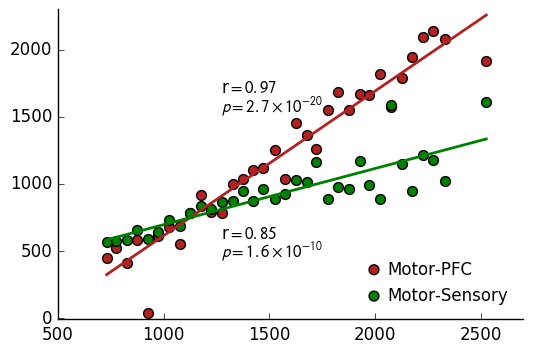

In [18]:
f, ax = plt.subplots()
rts = df['RT bin']
mot_pfc = df['Mot/PFC']
mot_sens = df['Mot/Sens']

points_grp = ax.scatter(rts, mot_pfc, marker = 'o', s=50, color = 'firebrick', edgecolor = 'k', label = 'Motor-PFC')
points_ctrl = ax.scatter(rts, mot_sens, marker = 'o', s=50, color = 'green', edgecolor = 'k', label = 'Motor-Sensory')

R, p = stats.pearsonr(mot_pfc, rts)
A = np.vstack([rts,np.ones(len(rts))]).T
m,c = np.linalg.lstsq(A,np.array(mot_pfc))[0]
ax.plot(rts,rts*m+c, color = 'firebrick', linewidth = 2, label='_nolegend_')
ax.text(0.35, 0.65, r"$p = $%s" %(sci_notation(p, exponent = False)), transform = ax.transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 12)        
ax.text(0.35, 0.72, r"r$ = {%.2f}$" %(R), transform = ax.transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 12)


R, p = stats.pearsonr(mot_sens, rts)
A = np.vstack([rts,np.ones(len(rts))]).T
m,c = np.linalg.lstsq(A,np.array(mot_sens))[0]
ax.plot(rts,rts*m+c, color = 'green', linewidth = 2, label='_nolegend_')
ax.text(0.35, 0.18, r"$p = $%s" %(sci_notation(p, exponent = False)), transform = ax.transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 12)        
ax.text(0.35, 0.25, r"r$ = {%.2f}$" %(R), transform = ax.transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 12)

leg = ax.legend(fontsize=12, scatterpoints = 1, loc='lower right', frameon = False)#, bbox_to_anchor=(1, 1.03))

ax.patch.set_facecolor('white')
ax.autoscale(tight=False)
ax.set_ylim([-10,2300])
ax.set_xlim([500,2700])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.yaxis.set_tick_params(labelsize = 12)
ax.xaxis.set_tick_params(labelsize = 12)

filename = os.path.join(savedir, 'crossover_corr.png')
plt.savefig(filename, dpi = 150)

In [19]:
filename

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI/crossover_corr.png'

## scatter plot for bin params

In [7]:
filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'Bin_Stats_v1_D+R.csv')
df = pd.read_csv(filename)

# filename = os.path.join(savedir, 'binned_RTs_withresp.csv')
# df_values = pd.read_csv(filename)

filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'Bin_Stats_v1_RegressionValues.csv')
dfAmp = pd.read_csv(filename)

filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'Bin_Stats_v1_RegressionLat.csv')
dfLat = pd.read_csv(filename)

#match bins to regression
#df = df.iloc[np.in1d(df.RT.values, dfAmp.RT.values)]
# df_values['rts'] = df_values.rts.apply(floor)
# df_values = df_values.iloc[np.in1d(df_values.rts.values, dfAmp.RT.values)]

#extract values (regression)
rts = dfAmp['RT']
means_d = dfAmp['mean Dur (t4:t2)']
amp_r = dfAmp['Resp peak']
t2 = dfLat['t2 (last cross)']
mean_r = dfAmp['mean Resp (t4:t2)']



In [34]:
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

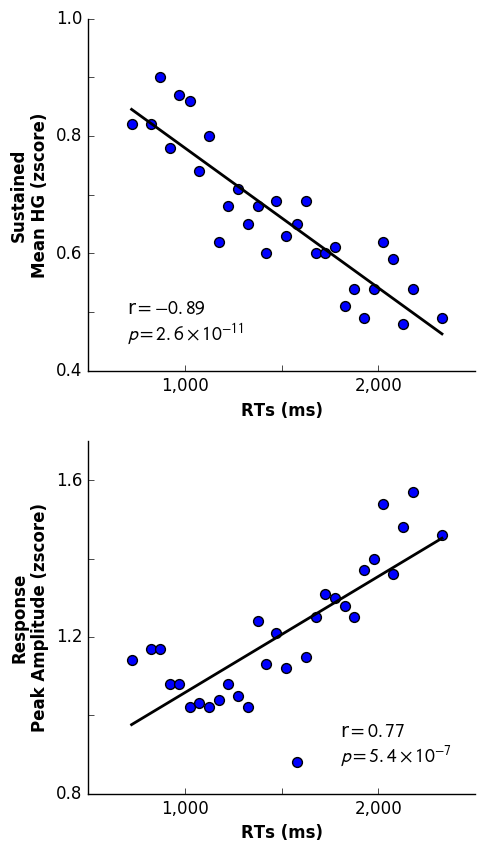

In [35]:
#plot
f, ax = plt.subplots(2,1, figsize = (5,10))
ax = ax.flatten()

ax[0].scatter(rts[~(np.isnan(means_d))], means_d.dropna(), marker = 'o', s=50)
ax[0].set_ylabel('Sustained\nMean HG (zscore)',weight = 'bold', fontsize = 12)
R, p = stats.pearsonr(means_d.dropna(), rts[~(np.isnan(means_d))])
A = np.vstack([rts[~(np.isnan(means_d))],np.ones(len(rts[~(np.isnan(means_d))]))]).T
m,c = np.linalg.lstsq(A,np.array(means_d.dropna()))[0]
ax[0].plot(rts[~(np.isnan(means_d))],rts[~(np.isnan(means_d))]*m+c, color = 'k', linewidth = 2)
ax[0].text(0.1, 0.15, r"r$ = {%.2f}$" %(R), transform = ax[0].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 14)
ax[0].text(0.1, 0.07, r"$p = $%s" %(sci_notation(p)), transform = ax[0].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 14)
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax[1].scatter(rts, amp_r, marker = 'o', s=50)
ax[1].set_ylabel('Response\nPeak Amplitude (zscore)',weight = 'bold', fontsize = 12)
R, p = stats.pearsonr(amp_r, rts)
A = np.vstack([rts,np.ones(len(rts))]).T
m,c = np.linalg.lstsq(A,np.array(amp_r))[0]
ax[1].plot(rts,rts*m+c, color = 'k', linewidth = 2)
ax[1].text(0.65, 0.15, r"r$ = {%.2f}$" %(R), transform = ax[1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 14)
ax[1].text(0.65, 0.07, r"$p = $%s" %(sci_notation(p)), transform = ax[1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 14)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


for i in np.arange(0,2):
    ax[i].patch.set_facecolor('white')
    ax[i].autoscale(tight=False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    ax[i].xaxis.set_tick_params(labelsize = 12)
    ax[i].yaxis.set_tick_params(labelsize = 12)
    ax[i].tick_params( axis='both', which = 'both', top = 'off', bottom = 'on', right = 'off', left = 'on')
    ax[i].spines['bottom'].set_bounds(500, 2500)
    ax[i].set_xticks(np.arange(1000, 2500, 500))
    plt.setp(ax[i].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[i].get_yticklabels()[1::2], visible=False)
    ax[i].set_xlabel('RTs (ms)',weight = 'bold', fontsize = 12)
    ax[i].set_xlim([500, 2500])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)


#f.subplots_adjust(hspace = 0.25)
    
filename = os.path.join(savedir, 'binned_RTs_regression_corrs.png')
f.savefig(filename,bbox_inches='tight', dpi = 150)